In [1]:
import os
import psutil
import pickle
import random
import gzip
import gc
from time import time
from tqdm import tqdm
import cv2
from collections import OrderedDict

import numpy as np
import pandas as pd
import torch
from torch.backends import cudnn
import torch.nn as nn
import torch.nn.functional as func
from torch.utils import data
from torch.utils.data import Subset, DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset, Subset

from emm_regressor import Trainer, ModelBase

INPUT_FOLDER = '../input/made2-hw2-segmentation-data-multi'
SEED=42

def reseed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


reseed()

In [2]:
START_CHECKPOINT=None

VAL_SPLIT = 0.1
EPOCHS = 100
BATCH_SIZE = 256
SAMPLE = False
WEIGHT_DECAY = 0

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    SAMPLE = True
    EPOCHS = 2

In [3]:
class ModelSegmentation(ModelBase):
    def __init__(self, model, device, pos_weight):
        super().__init__(model, device)
        self.pos_weight = pos_weight
        self.loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.cur_eval_index = 0
        self.samples_count = 0

    def train_batch(self, X, y, optimizer):
        prediction = self.model(X.to(self.device)).reshape(y.shape)
        y_dev = y.to(self.device)
        loss_value = self.loss(prediction, y_dev.type_as(prediction)).mean(dim=-1)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        prediction = (prediction > 0).long().detach().cpu()
        acc = torch.mean((prediction == y.long()).float()).item()
        loss = loss_value.item()
        return {"loss": loss, "train_acc": acc }

    def eval_begin(self, total_size):
        self.model.eval()
        self.ground_truth = None
        self.predictions = None
        self.cur_eval_index = 0
        self.samples_count = total_size

    def eval_batch(self, X, y):
        prediction = self.model(X.to(self.device)).reshape(y.shape)
        return torch.sigmoid(prediction).detach().cpu()

    def eval_append_results(self, predictions, ground_truth):
        new_index = self.cur_eval_index + len(ground_truth)
        if self.ground_truth is None:
            self.ground_truth = np.zeros((self.samples_count, predictions.shape[1], predictions.shape[2]), dtype=np.uint8)
            self.predictions = np.zeros((self.samples_count, predictions.shape[1], predictions.shape[2]), dtype=np.uint8)
        self.ground_truth[self.cur_eval_index:new_index, :, :] = (ground_truth.numpy()*255).astype(np.uint8)
        self.predictions[self.cur_eval_index:new_index, :, :] = (predictions.numpy()*255).astype(np.uint8)
        self.cur_eval_index = new_index

    def evaluate(self, prediction, ground_truth, **kwargs):
        prediction = (prediction > 127).astype(np.long)
        ground_truth = (ground_truth > 127).astype(np.long)
        N = prediction.size
        predicted_positive = int(prediction.sum())
        ground_positive = int(ground_truth.sum())
        TP = int((prediction * ground_truth).sum())
        FP = predicted_positive - TP
        FN = ground_positive - TP
        TN = N - FP - FN - TP
        precision = TP / predicted_positive if predicted_positive > 0 else 1
        recall = TP / ground_positive if ground_positive > 0 else 1
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        return {"TP": TP / N, "TN": TN / N, "FP": FP / N, "FN": FN / N, "acc": (TP + TN) / N, "prec": precision, "rec": recall, "F1": f1}

    def eval_complete(self, **kwargs):
        return self.predictions, self.ground_truth

    def epoch_metrics_format(self):
        return "LR:{learning_rate:.6f}, loss:{loss:.4f}, train_acc:{train_acc:.3f}, val_acc:{acc:.3f}, val_f1:{F1:.3f}"

    def batch_metrics_format(self):
        return "loss:{loss:.4f}, acc:{train_acc:.4f}"

    def target_metric(self):
        return "F1"

In [4]:
class CarPlateSegmentationDataset(Dataset):
    def __init__(self, folder=INPUT_FOLDER, sample=SAMPLE):
        with gzip.open(os.path.join(folder,'images_sample.pth' if sample else 'images.pth'), 'rb', 5) as f:
            self.images = pickle.load(f)
        with gzip.open(os.path.join(folder,'masks_sample.pth' if sample else 'masks.pth'), 'rb', 5) as f:
            self.masks = pickle.load(f)
        with gzip.open(os.path.join(folder,'meta_sample.pickle' if sample else 'meta.pickle'), 'rb', 5) as f:
            self.boxes, self.texts, self.filenames, _ = pickle.load(f)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]/255.0, self.masks[index]//255 #.reshape(-1)

    def pos_weight(self):
        s = self.masks.shape
        pos_points = self.masks.sum()/255.0
        neg_points = s[0]*s[1]*s[2] - pos_points
        return neg_points/pos_points
    
    def X_shape(self):
        return self.images[0].shape
    
    def y_shape(self):
        return self.masks[0].reshape(-1).shape
    
dataset = CarPlateSegmentationDataset()
IMG_SIZE = dataset.X_shape()[1:]
Y_SHAPE = dataset.y_shape()
POS_WEIGHT = dataset.pos_weight()

indices = np.arange(len(dataset))
np.random.shuffle(indices)
val_split = int(VAL_SPLIT*len(indices))

val_dataset = Subset(dataset, indices[:val_split])
train_dataset = Subset(dataset, indices[val_split:])

In [5]:
#https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1) #torch.sigmoid()

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [6]:
model = UNet(in_channels=3, out_channels=1, init_features=8)

model = model.to(device)

trainer = Trainer(ModelSegmentation(model, device, POS_WEIGHT),
                  lambda model: torch.optim.AdamW(model.model.parameters(), lr=3E-4, weight_decay=WEIGHT_DECAY),
                  train_dataset=train_dataset, val_dataset=val_dataset, batch_size=BATCH_SIZE, outdir='./', start_from_checkpoint=START_CHECKPOINT,
                  n_best_models=2, min_val_score=-3, verbose=False)

reseed(SEED + trainer.total_epochs)

In [7]:
trainer.train(EPOCHS, start_lr=3E-4, end_lr=1E-4, warmup=100)

----------------------------------------------------------------------------------
Training epochs 0=>100  {'start_lr': 0.0003, 'end_lr': 0.0001, 'warmup': 100}
----------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train epoch	[  1/100]	(0:01:02<=1:43:20s)	LR:0.000297, loss:0.9670, train_acc:0.822, val_acc:0.955, val_f1:0.261
Train epoch	[  2/100]	(0:02:04<=1:41:38s)	LR:0.000294, loss:0.5193, train_acc:0.961, val_acc:0.968, val_f1:0.346
Train epoch	[  3/100]	(0:03:06<=1:40:25s)	LR:0.000290, loss:0.4315, train_acc:0.978, val_acc:0.977, val_f1:0.426
Train epoch	[  4/100]	(0:04:08<=1:39:12s)	LR:0.000287, loss:0.3742, train_acc:0.984, val_acc:0.988, val_f1:0.585
Train epoch	[  5/100]	(0:05:09<=1:38:09s)	LR:0.000284, loss:0.3313, train_acc:0.987, val_acc:0.989, val_f1:0.603
Train epoch	[  6/100]	(0:06:12<=1:37:12s)	LR:0.000281, loss:0.2952, train_acc:0.988, val_acc:0.991, val_f1:0.651
Train epoch	[  7/100]	(0:07:14<=1:36:09s)	LR:0.000278, loss:0.2639, train_acc:0.990, val_acc:0.991, val_f1:0.650
Train epoch	[  8/100]	(0:08:16<=1:35:05s)	LR:0.000275, loss:0.2344, train_acc:0.991, val_acc:0.990, val_f1:0.636
Train epoch	[  9/100]	(0:09:18<=1:34:04s)	LR:0.000272, loss:0.2096, train_acc:0.992, val_acc:0.9

In [8]:
def predict(trainer, dataset):
    predictions, gt = trainer.predict(dataset)
    return predictions.reshape(-1, IMG_SIZE[0], IMG_SIZE[1]), gt.reshape(-1, IMG_SIZE[0], IMG_SIZE[1])

def draw_predictions(dataset, predictions, samples=8, cols=4, alpha=0.8, color=(0,255,0)):
    indices = np.random.choice(len(dataset), size=samples, replace=False)
    rows = samples // cols
    plt.figure(figsize=(24, rows * 18 / cols))
    for i, idx in enumerate(indices):
        image = (dataset[idx][0].permute(1, 2, 0).numpy()*255).astype(np.uint8)
        mask = predictions[idx,:,:]
        mask = mask[:,:,None]*alpha / 255.0
        image = (image * (1 - mask) + (mask @ np.array(color)[None,:])).astype(np.uint8)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

In [9]:
%%time
val_predictions, _ = predict(trainer,val_dataset)

CPU times: user 1.71 s, sys: 826 ms, total: 2.53 s
Wall time: 2.54 s


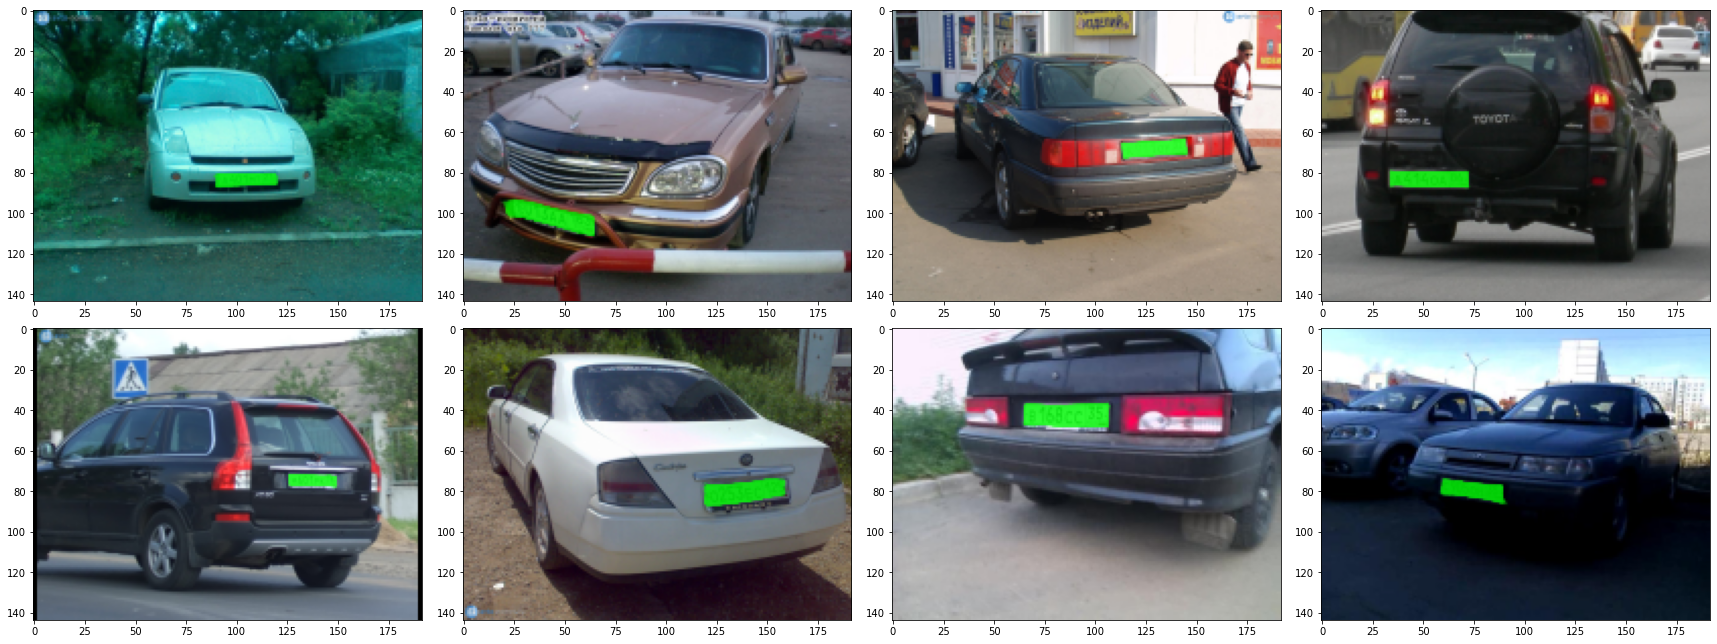

CPU times: user 2.32 s, sys: 9.84 ms, total: 2.33 s
Wall time: 2.52 s


In [10]:
%%time
draw_predictions(val_dataset, val_predictions)

In [11]:
trainer.epoch_logger.print_logs()

----------------------------------------------------------------------------------
Training epochs 0=>100  {'start_lr': 0.0003, 'end_lr': 0.0001, 'warmup': 100}
----------------------------------------------------------------------------------
Train epoch	[  1/100]	(0:01:02<=1:43:20s)	LR:0.000297, loss:0.9670, train_acc:0.822, val_acc:0.955, val_f1:0.261
Train epoch	[  2/100]	(0:02:04<=1:41:38s)	LR:0.000294, loss:0.5193, train_acc:0.961, val_acc:0.968, val_f1:0.346
Train epoch	[  3/100]	(0:03:06<=1:40:25s)	LR:0.000290, loss:0.4315, train_acc:0.978, val_acc:0.977, val_f1:0.426
Train epoch	[  4/100]	(0:04:08<=1:39:12s)	LR:0.000287, loss:0.3742, train_acc:0.984, val_acc:0.988, val_f1:0.585
Train epoch	[  5/100]	(0:05:09<=1:38:09s)	LR:0.000284, loss:0.3313, train_acc:0.987, val_acc:0.989, val_f1:0.603
Train epoch	[  6/100]	(0:06:12<=1:37:12s)	LR:0.000281, loss:0.2952, train_acc:0.988, val_acc:0.991, val_f1:0.651
Train epoch	[  7/100]	(0:07:14<=1:36:09s)	LR:0.000278, loss:0.2639, train_acc:

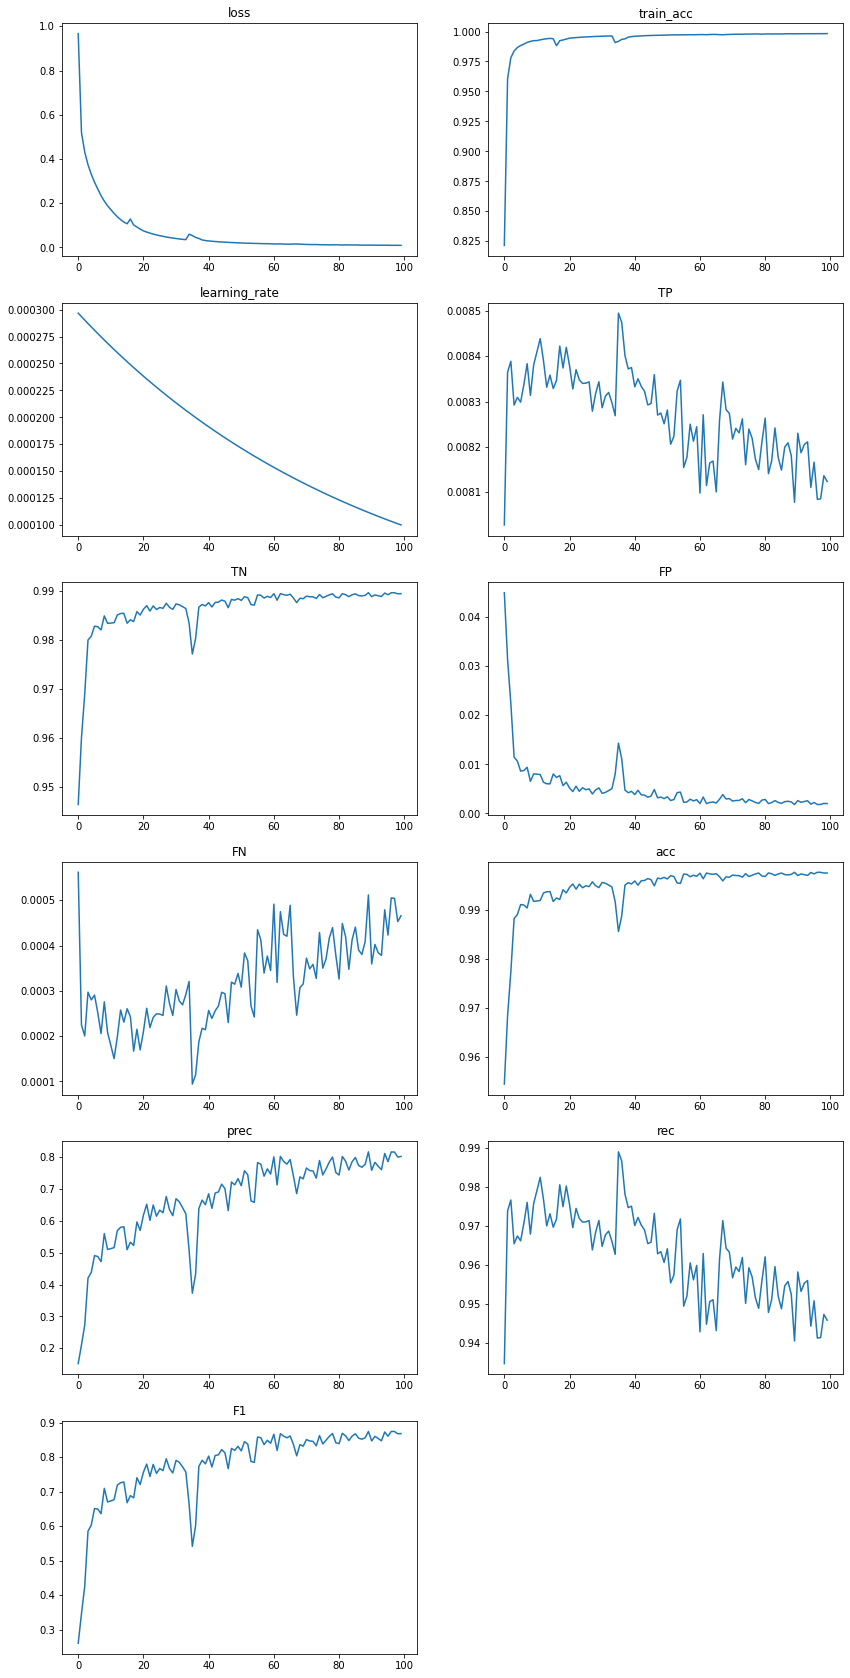

In [12]:
trainer.epoch_logger.plot_logs(cols=2)